# Task 1 - Analyze the GitHub Social Network

- *Load Raw Github Network dataset and the normalized feature-rich Network dataset*
- *Define function to prepare a sample for network visualization*
- *Visualize Network with respect to Edge Betweenness*
- *Visualize Network with Node Betweenness*
- *Visualize Feature Correlation with a Heatmap*
- *Visualize Feature Influence toward Class 0 or 1 with Scatter Plots*
- *Visualize Distribution of Features with Kernel Density Estimate (KDE) Plot*
- *Visualize Feature Relationships with respect to Classes with a Pair Plot*
- *Visualize Degree Distribution of the Network*
- *Visualize the Cummulative Degree Distribution*


In [1]:
#import all the needed libraries
import pandas as pd
import numpy as np
import networkx as nx
import xgboost as xgb
import matplotlib.pyplot as plt
import seaborn as sns
import os
import random
import pickle
import warnings
warnings.filterwarnings('ignore')
import shap
from sklearn.model_selection import train_test_split

In [2]:
# Load GitHub Network data

data = open('./data/musae_git_edges.csv')
next(data) # Skip first line coz header
graph = nx.read_edgelist(data, create_using=nx.DiGraph(), delimiter=',', nodetype=int)
print('Graph Details')
print(graph)

Graph Details
DiGraph with 37700 nodes and 289003 edges


In [3]:
# Now, the normalized data
df = pd.read_csv('./data/github-normalized-dataset.csv')
df = df.drop(columns=['Unnamed: 0'])
df.head(10)

,Source,Target,Class,Page_Rank_Source,Page_Rank_Target,Shortest_Path,Source_Followers,Source_Following,Target_Followers,Target_Following,Mutual_Followers,Mutual_Following
0,0,23977,1,0.000849,0.002297,0.571429,0.000803,0.000880,0.003479,0.002347,0.0,0.000000
1,1,34526,1,0.000993,0.002706,0.714286,0.001204,0.002054,0.001338,0.001027,0.0,0.000000
2,1,2370,1,0.000993,0.001400,0.571429,0.001204,0.002054,0.001873,0.006895,0.0,0.001548
3,1,14683,1,0.000993,0.004727,0.714286,0.001204,0.002054,0.007225,0.010562,0.0,0.001548
4,1,29982,1,0.000993,0.037747,0.428571,0.001204,0.002054,0.052850,0.015989,0.0,0.000000
5,1,21142,1,0.000993,0.030861,0.428571,0.001204,0.002054,0.052582,0.044888,0.0,0.001548
6,1,20363,1,0.000993,0.008405,0.571429,0.001204,0.002054,0.018464,0.040487,0.0,0.003096
7,1,23830,1,0.000993,0.003113,0.571429,0.001204,0.002054,0.004282,0.002640,0.0,0.000000
8,1,34035,1,0.000993,0.001135,0.714286,0.001204,0.002054,0.001338,0.001467,0.0,0.000000
9,6067,19720,1,0.001813,0.001829,0.714286,0.001338,0.000880,0.002141,0.005574,0.0,0.000000


In [4]:
# Function to prepare a sample from graph for generating network plot
def prepare_sampled_graph(graph, num_edges=500, seed=42):
    
    sampled_edges = random.sample(list(graph.edges), num_edges)
    sampled_graph = nx.DiGraph()
    sampled_graph.add_edges_from(sampled_edges)
    sampled_graph = nx.convert_node_labels_to_integers(G=sampled_graph, first_label=0)
    layout = nx.spring_layout(sampled_graph, seed=seed)

    return sampled_graph, layout

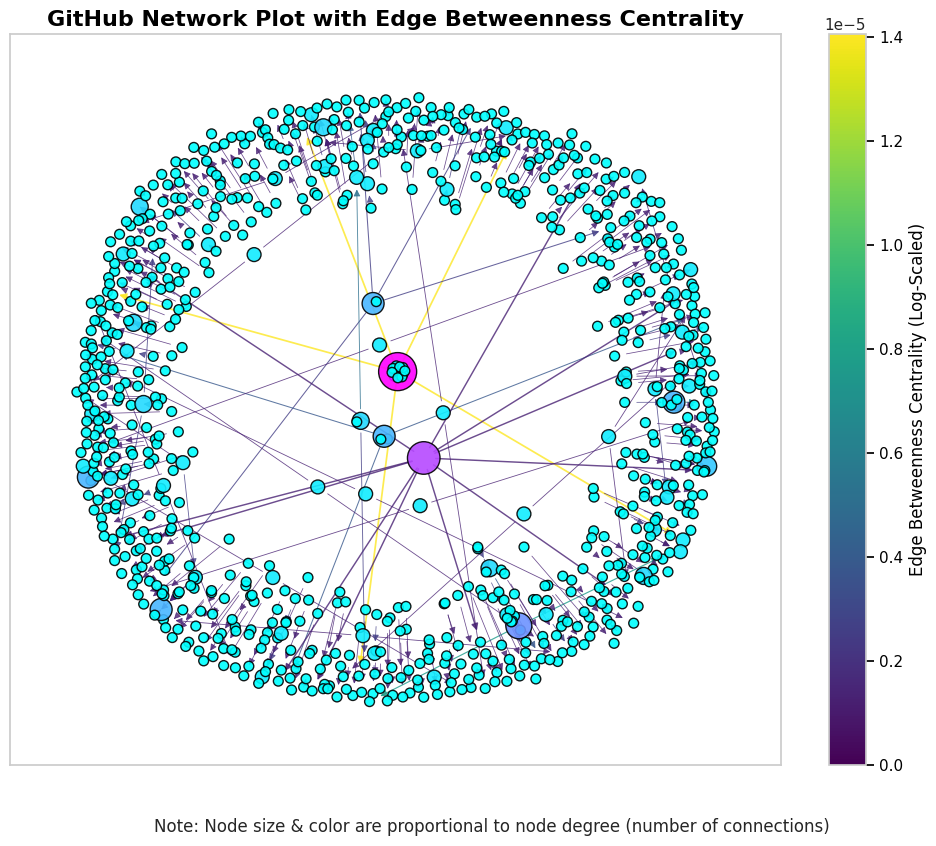

In [23]:
# 1. GitHub Social Network with Edge Betweenness Visualized

sampled_graph, layout = prepare_sampled_graph(graph)

# Calculate edge betweenness centrality
edge_betweenness = nx.edge_betweenness_centrality(sampled_graph)
centrality_values = list(edge_betweenness.values())
log_scaled_values = np.log1p(centrality_values)
norm_centrality = np.array(log_scaled_values) / log_scaled_values.max()


# Set edge colors based on betweenness centrality
edge_colors = plt.cm.viridis(norm_centrality)

# Set node sizes based on degree
node_degrees = dict(sampled_graph.degree())
node_sizes = [degree * 50 for degree in node_degrees.values()]
edge_thickness = [0.5 + node_degrees[u] * 0.05 for u, v in sampled_graph.edges()]
plt.figure(figsize=(10, 8), facecolor='white')
ax = plt.gca()
ax.set_facecolor('white')
ax.grid(False)


# Draw nodes and edges
nodes = nx.draw_networkx_nodes(
    sampled_graph,
    layout,
    node_color=list(node_degrees.values()),
    cmap='cool',
    node_size=node_sizes,
    alpha=0.9,
    edgecolors='black'
)
edges = nx.draw_networkx_edges(
    sampled_graph,
    layout,
    edge_color=edge_colors,
    width=edge_thickness,
    alpha=0.8
)

plt.title('GitHub Network Plot with Edge Betweenness Centrality', fontsize=16, fontweight='bold', color='black')

# Add colorbar for edge betweenness centrality
sm = plt.cm.ScalarMappable(cmap='viridis', norm=plt.Normalize(vmin=0, vmax=log_scaled_values.max()))
sm.set_array([])
cbar = plt.colorbar(sm, ax=ax)
cbar.set_label('Edge Betweenness Centrality (Log-Scaled)', color='black', fontsize=12)
cbar.ax.yaxis.set_tick_params(color='black')
plt.setp(plt.getp(cbar.ax.axes, 'yticklabels'), color='black')
plt.figtext(0.5, -0.05, "Note: Node size & color are proportional to node degree (number of connections)", wrap=True, horizontalalignment='center', fontsize=12)

plt.tight_layout()
plt.show()


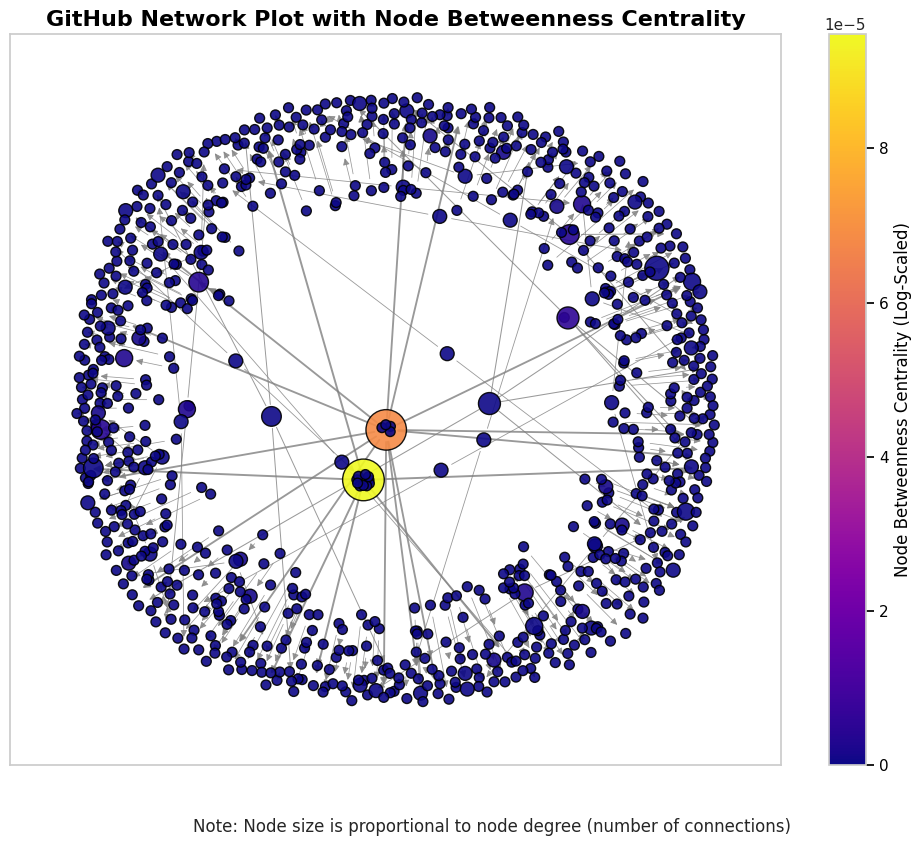

In [35]:
# 2. GitHub Social Network with Node Betweenness Visualized

sampled_graph, layout = prepare_sampled_graph(graph)

# Calculate node betweenness centrality
node_betweenness = nx.betweenness_centrality(sampled_graph)
betweenness_values = np.array(list(node_betweenness.values()))
log_betweenness_values = np.log1p(betweenness_values)
norm_betweenness = log_betweenness_values / log_betweenness_values.max()

node_degrees = dict(sampled_graph.degree())
node_sizes = [degree * 50 for degree in node_degrees.values()]

# Adjust length of edges using source node's degree
edge_thickness = [0.5 + node_degrees[u] * 0.05 for u, v in sampled_graph.edges()]

plt.figure(figsize=(10, 8), facecolor='white')
ax = plt.gca()
ax.set_facecolor('white')
ax.grid(False)

# Draw nodes and edges
nodes = nx.draw_networkx_nodes(
    sampled_graph,
    layout,
    node_color=norm_betweenness,
    cmap='plasma', 
    node_size=node_sizes,
    alpha=0.9,
    edgecolors='black'
)
edges = nx.draw_networkx_edges(
    sampled_graph,
    layout,
    edge_color='gray',
    width=edge_thickness,
    alpha=0.8
)

plt.title('GitHub Network Plot with Node Betweenness Centrality', fontsize=16, fontweight='bold', color='black')

# Add colorbar for node betweenness
sm = plt.cm.ScalarMappable(cmap='plasma', norm=plt.Normalize(vmin=0, vmax=log_betweenness_values.max()))
sm.set_array([])
cbar = plt.colorbar(sm, ax=ax)
cbar.set_label('Node Betweenness Centrality (Log-Scaled)', color='black', fontsize=12)
cbar.ax.yaxis.set_tick_params(color='black')
plt.setp(plt.getp(cbar.ax.axes, 'yticklabels'), color='black')


plt.figtext(0.5, -0.05, "Note: Node size is proportional to node degree (number of connections)", wrap=True, horizontalalignment='center', fontsize=12)
plt.tight_layout()
plt.show()

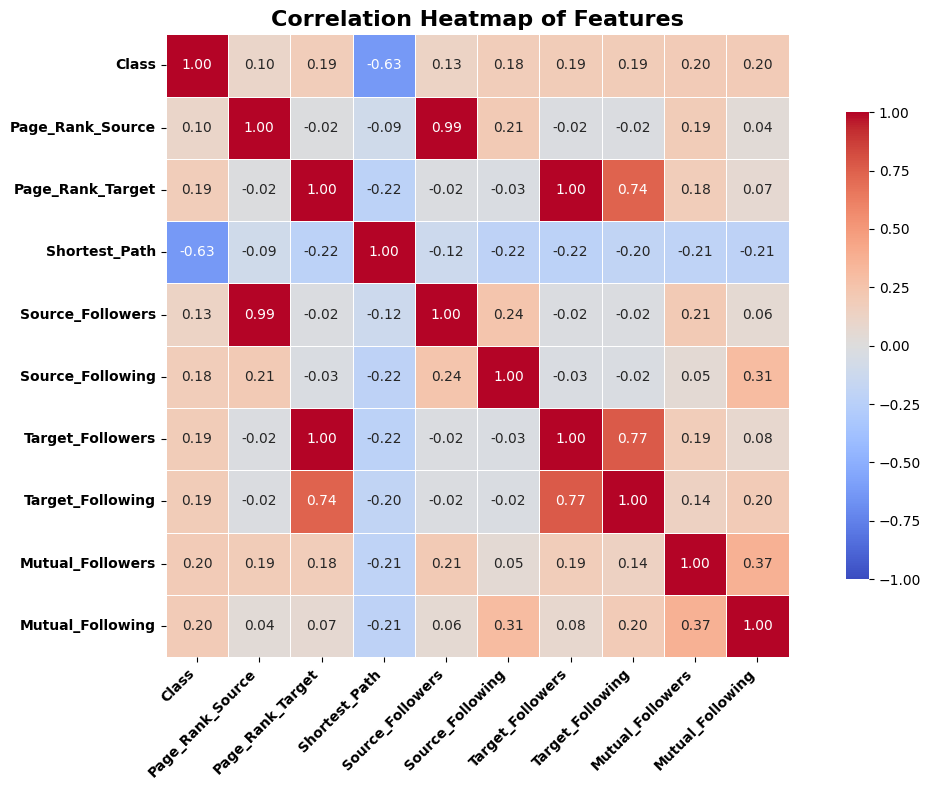

In [6]:
# 3. Feature Correlation visualized with Heatmap

plt.figure(figsize=(12, 8))

# Drop Source and Target columns for correlation matrix
corr_matrix = df.drop(columns=['Source', 'Target']).corr()

# heat-map
ax = sns.heatmap(
    corr_matrix,
    vmin=-1, vmax=1, center=0, 
    cmap='coolwarm',  
    annot=True,  
    fmt=".2f",
    square=True,  
    linewidths=0.5,  
    cbar_kws={"shrink": 0.75}, 
)

# x-axis labels
ax.set_xticklabels(
    ax.get_xticklabels(),
    rotation=45,
    horizontalalignment='right',
    fontsize=10,
    fontweight='bold'
)

# y-axis labels
ax.set_yticklabels(
    ax.get_yticklabels(),
    rotation=0,
    horizontalalignment='right',
    fontsize=10,
    fontweight='bold'
)

plt.title('Correlation Heatmap of Features', fontsize=16, fontweight='bold')
plt.tight_layout()
plt.show()

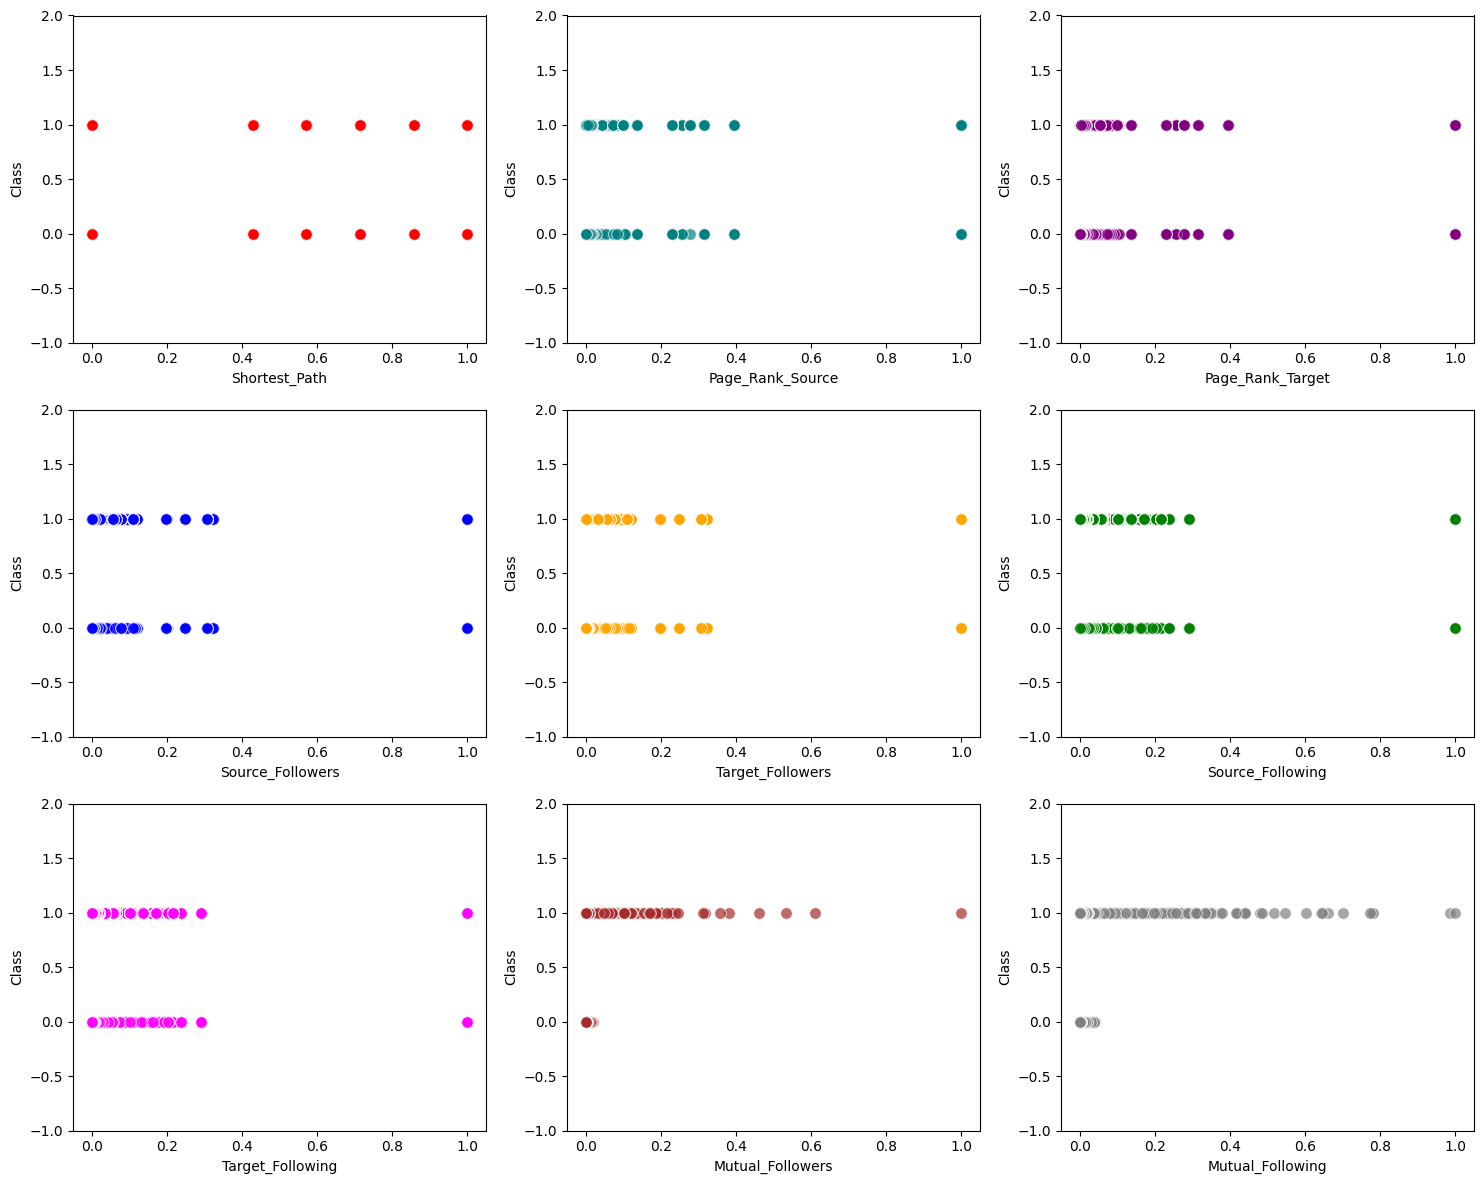

In [7]:
# 4. Feature Influence toward Class 0 or 1 visualized with Scatter Plots

dims = (15, 12)
fig, axes = plt.subplots(nrows=3, ncols=3, figsize=dims)

sns.set(style="whitegrid")
color_palette = ['red', 'teal', 'purple', 'blue', 'orange', 'green', 'magenta', 'brown', 'grey']


sns.scatterplot(x='Shortest_Path', y='Class', data=df, ax=axes[0][0], color=color_palette[0], s=70, alpha=0.7)
sns.scatterplot(x='Page_Rank_Source', y='Class', data=df, ax=axes[0][1], color=color_palette[1], s=70, alpha=0.7)
sns.scatterplot(x='Page_Rank_Target', y='Class', data=df, ax=axes[0][2], color=color_palette[2], s=70, alpha=0.7)

sns.scatterplot(x='Source_Followers', y='Class', data=df, ax=axes[1][0], color=color_palette[3], s=70, alpha=0.7)
sns.scatterplot(x='Target_Followers', y='Class', data=df, ax=axes[1][1], color=color_palette[4], s=70, alpha=0.7)
sns.scatterplot(x='Source_Following', y='Class', data=df, ax=axes[1][2], color=color_palette[5], s=70, alpha=0.7)

sns.scatterplot(x='Target_Following', y='Class', data=df, ax=axes[2][0], color=color_palette[6], s=70, alpha=0.7)
sns.scatterplot(x='Mutual_Followers', y='Class', data=df, ax=axes[2][1], color=color_palette[7], s=70, alpha=0.7)
sns.scatterplot(x='Mutual_Following', y='Class', data=df, ax=axes[2][2], color=color_palette[8], s=70, alpha=0.7)


for ax in axes.flat:
    ax.set_ylim(-1, 2)

plt.tight_layout()
plt.show()


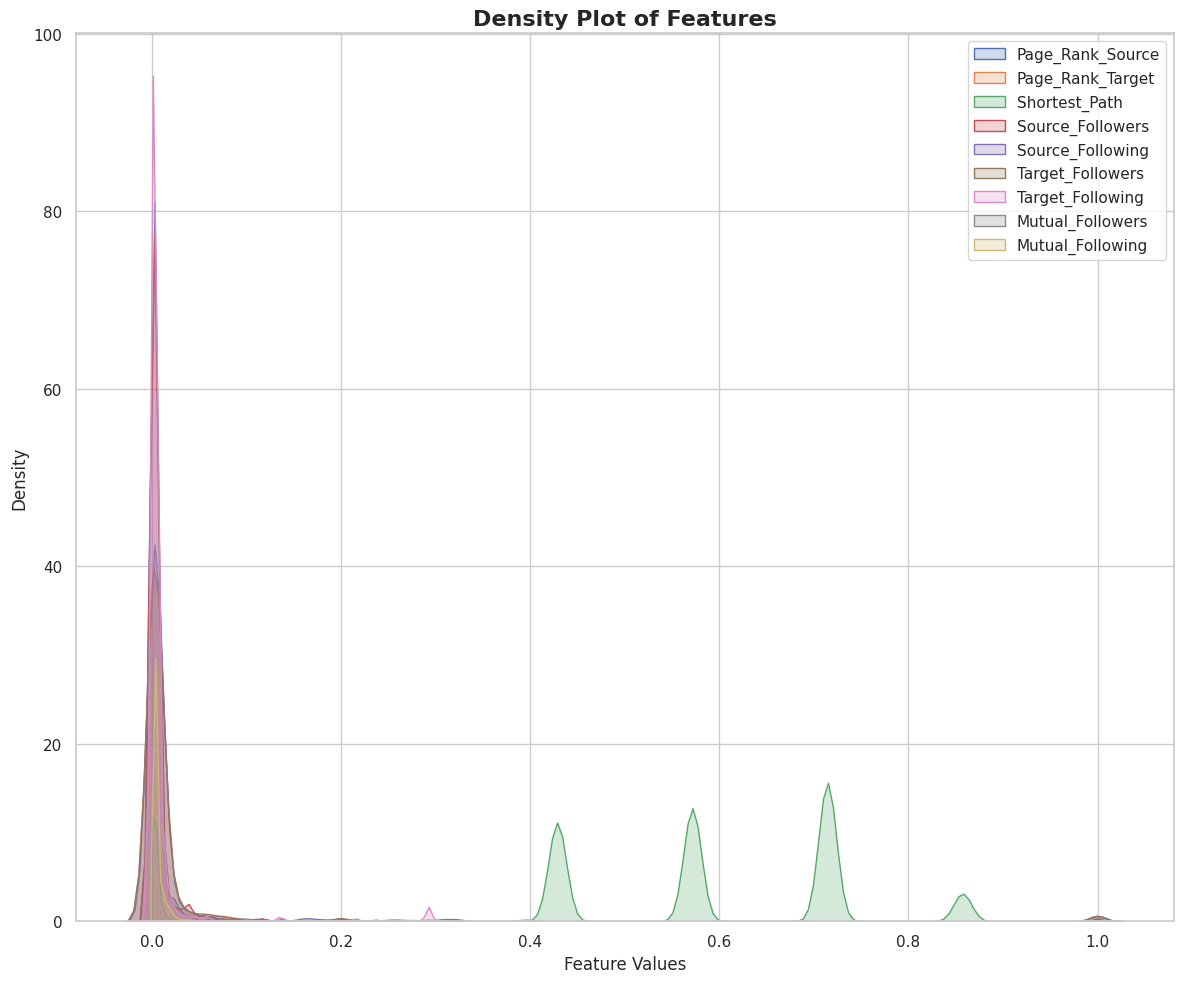

In [8]:
# 5. Distribution of Features visualized with Kernel Density Estimate (KDE) Plot

plt.figure(figsize=(12, 10))
for feature in df.columns.drop(['Class', 'Source', 'Target']):
    sns.kdeplot(df[feature], label=feature, fill=True)  # Kernel Density Estimate for each feature
plt.title('Density Plot of Features', fontsize=16, fontweight='bold')
plt.xlabel('Feature Values')  
plt.ylabel('Density')
plt.legend()
plt.tight_layout()
plt.show()


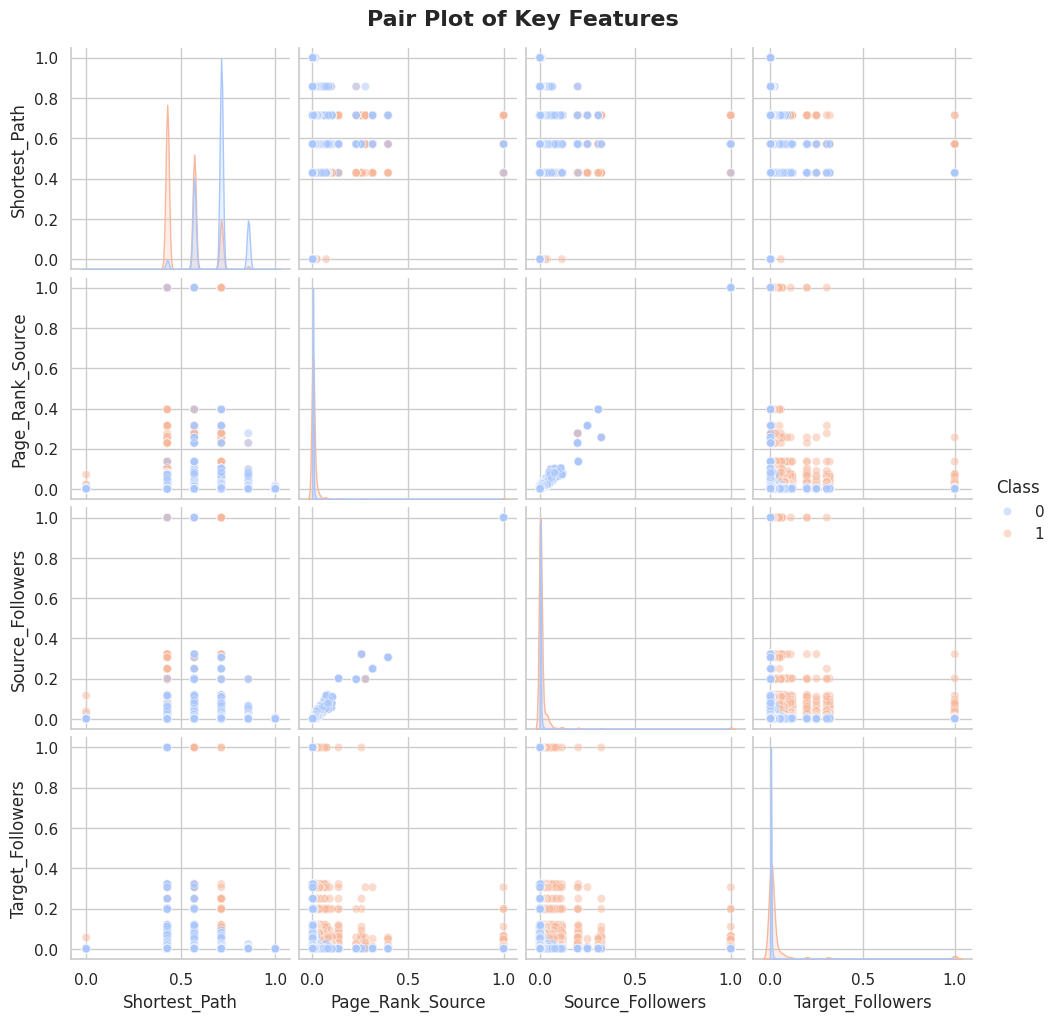

In [9]:
# 6. Feature Relationships w.r.t. Classes visualized with Pair Plot

sns.pairplot(df, vars=['Shortest_Path', 'Page_Rank_Source', 'Source_Followers', 'Target_Followers'], hue='Class', palette='coolwarm', plot_kws={'alpha': 0.5})
plt.suptitle('Pair Plot of Key Features', fontsize=16, fontweight='bold', y=1.02)
plt.show()

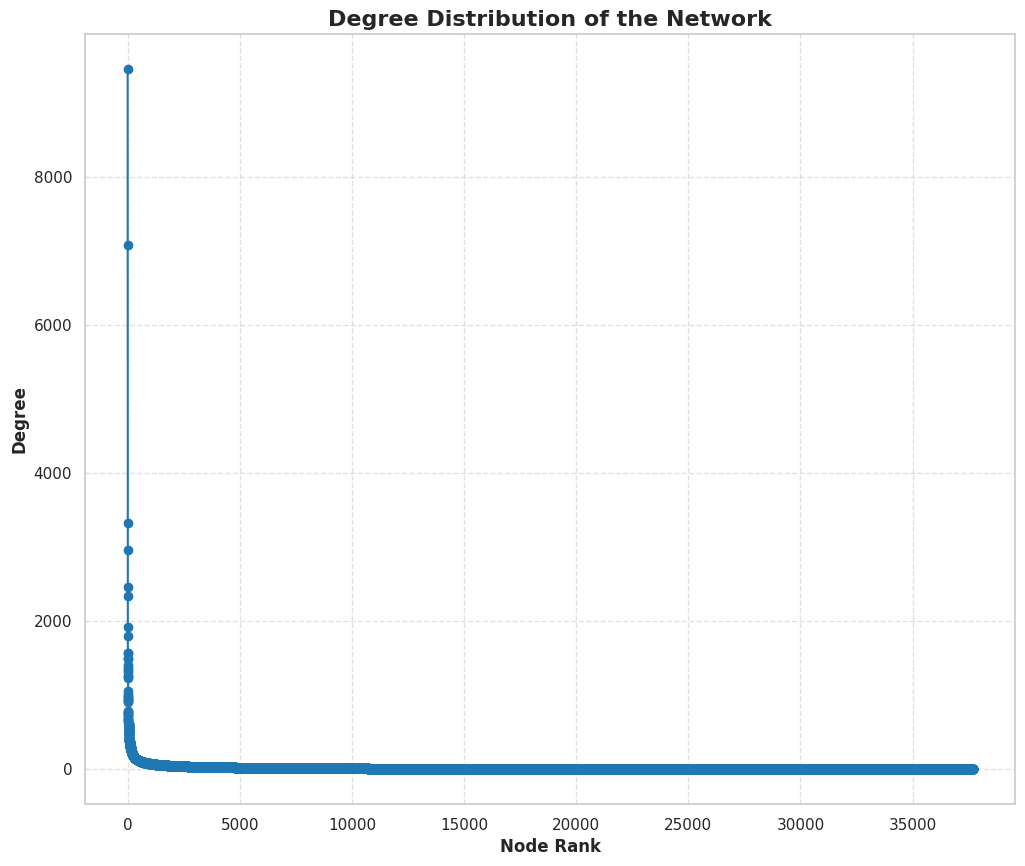

In [10]:
# 7. Ranking Nodes w.r.t. their Degrees using Degree Distribution Plot

# Sorting node degrees in descending order
degree_distribution_values = sorted([degree for node, degree in graph.degree()], reverse=True)
plt.figure(figsize=(12, 10))

plt.plot(degree_distribution_values, marker='o', linestyle='-', color='#1f77b4')
plt.title('Degree Distribution of the Network', fontsize=16, fontweight='bold')
plt.xlabel('Node Rank', fontsize=12, fontweight='bold')
plt.ylabel('Degree', fontsize=12, fontweight='bold')
plt.grid(True, linestyle='--', alpha=0.6)

plt.show()


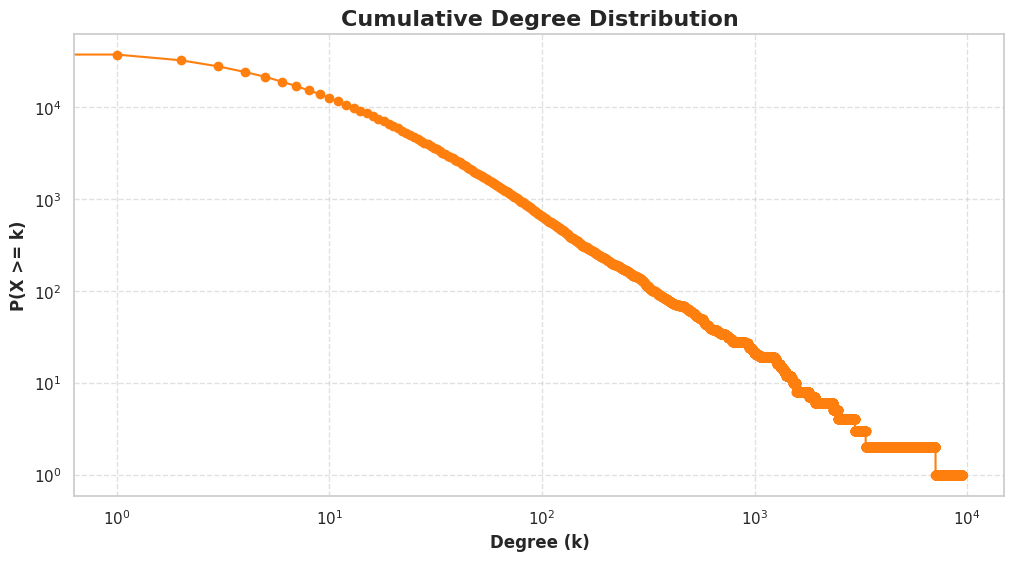

In [11]:
# 8. Fraction of Nodes with atleast Degree K visualized using Cumulative Degree Distribution Plot

degree_counts = nx.degree_histogram(graph)
degrees = range(len(degree_counts))
cumulative_degrees = [sum(degree_counts[i:]) for i in degrees]

plt.figure(figsize=(12, 6))
plt.loglog(degrees, cumulative_degrees, marker='o', color='#ff7f0e')
plt.title('Cumulative Degree Distribution', fontsize=16, fontweight='bold')
plt.xlabel('Degree (k)', fontsize=12, fontweight='bold')
plt.ylabel('P(X >= k)', fontsize=12, fontweight='bold')
plt.grid(True, linestyle='--', alpha=0.6)
plt.show()

# Task 2 - Analyze the GitHub Network with XGBoost Model & SHAP Values

- *Set Paths for XGBoost and SHAP Values*
- *Prepare dataset for training and testing*
- *Convert data into DMatrix format for XGBoost*
- *Set basic params such as objective, depth, learning_rate, estimators, eval metric*
- *Set params like tree_method and predictor for GPU Acceleration*
- *Train and Save model*
- *Generate SHAP Values using the trained model and training set*
- *Visualize Feature Influence in Link Prediction using Force Plots generated with SHAP Values*
- *Visualize Feature Importance with SHAP Summary Plot*
- *Visualize Feature Dependence with respect to the Most Important Feature with SHAP Dependence Plots*

In [12]:
# Paths for saving the model and SHAP values
xgb_model_path = './data/xgboost_model.pkl'
shap_values_path = './data/shap_values.pkl'

In [13]:
# Prepare the feature set X and the target variable y for model training
X = df.drop(columns=['Source', 'Target', 'Class'])
y = df['Class']  # Target class
x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)


if os.path.exists(xgb_model_path):
    with open(xgb_model_path, 'rb') as f:
        xgb_model = pickle.load(f)
    print('Pre-trained model loaded from disk.')
else:
    # Convert training and testing data into DMatrix for XGBoost processing
    dtrain = xgb.DMatrix(x_train, label=y_train)
    dtest = xgb.DMatrix(x_test, label=y_test)

    # Set XGBoost parameters
    params = {
        'objective': 'binary:logistic',  # Binary classification task
        'max_depth': 6,  # Maximum depth of the trees
        'learning_rate': 0.1,  # Learning rate for boosting
        'n_estimators': 100,  # Number of boosting rounds
        'eval_metric': 'auc'  # Area under the curve
        'tree_method': 'gpu_hist',  #  for training, GPU-based histogram works best apparently
        'predictor': 'gpu_predictor',  # GPU predictor
    }

    # Train
    xgb_model = xgb.train(params, dtrain, num_boost_round=100)

    # Saving it for future use
    with open(xgb_model_path, 'wb') as f:
        pickle.dump(xgb_model, f)
    print('New model trained and saved to file.')


New model trained and saved to file.


In [14]:
if os.path.exists(shap_values_path):
    print("Loading previously saved SHAP values...")
    with open(shap_values_path, 'rb') as file:
        shap_values = pickle.load(file)

    explainer = shap.Explainer(xgb_model, x_train)
else:
    print("Calculating new SHAP values...")

    # Generate SHAP values for the test dataset
    explainer = shap.Explainer(xgb_model, x_train)
    shap_values = explainer(x_test)

    # Save SHAP values
    with open(shap_values_path, 'wb') as file:
        pickle.dump(shap_values, file)
    print(f"SHAP values stored at {shap_values_path}")


Calculating new SHAP values...


100%|===================| 173053/173402 [07:11<00:00]        

SHAP values stored at ./data/shap_values.pkl


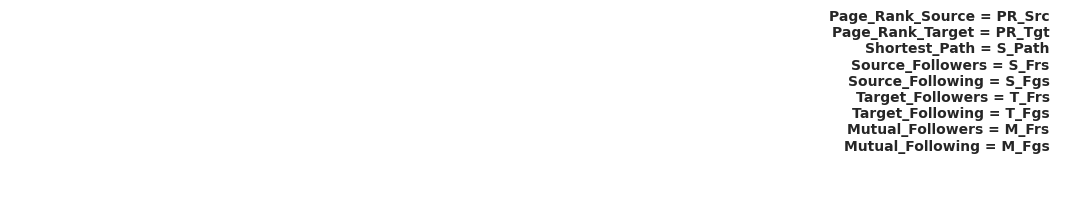

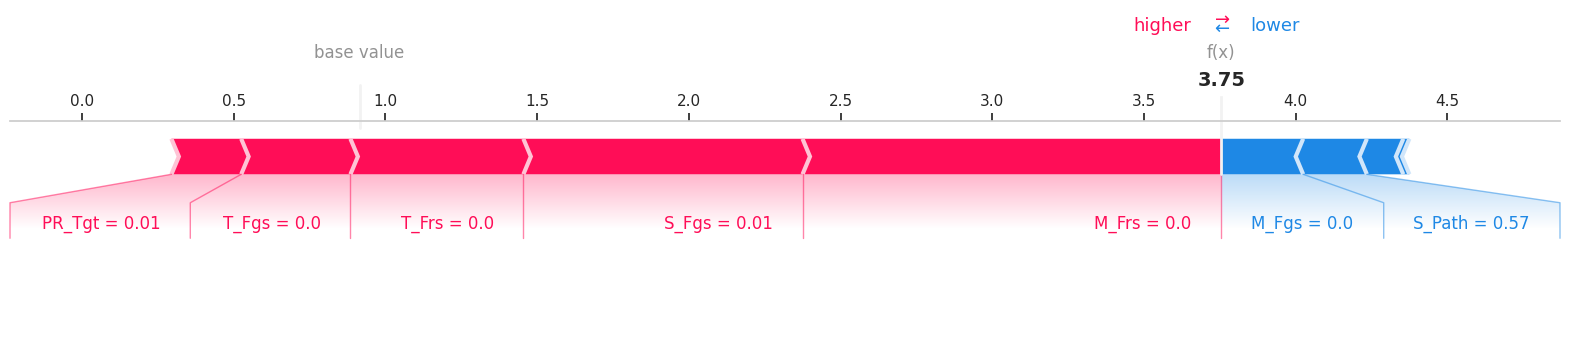

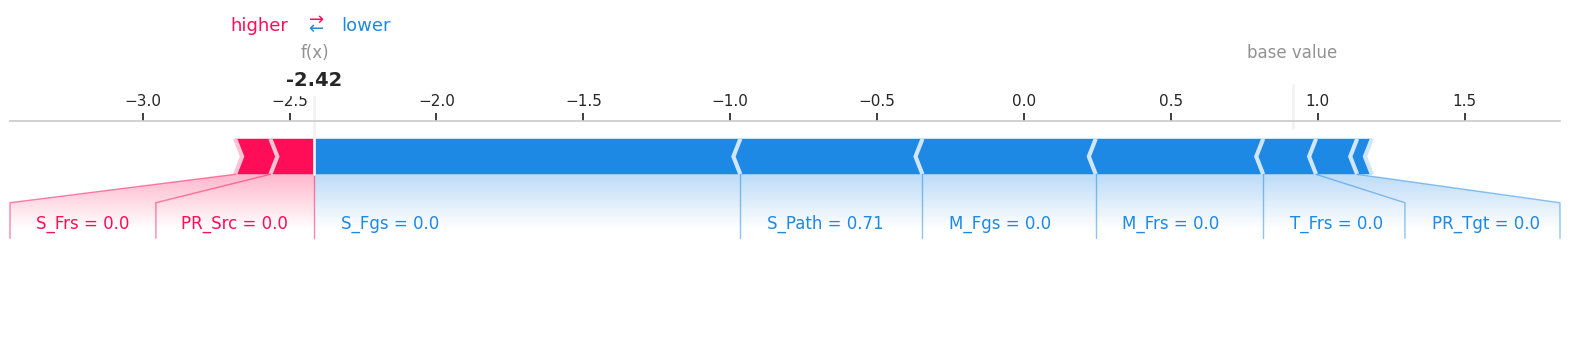

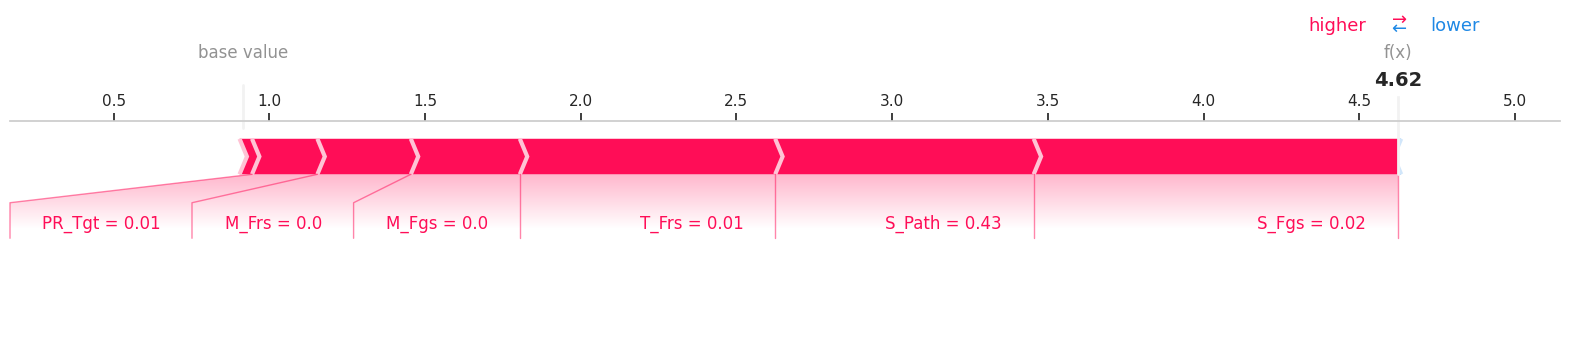

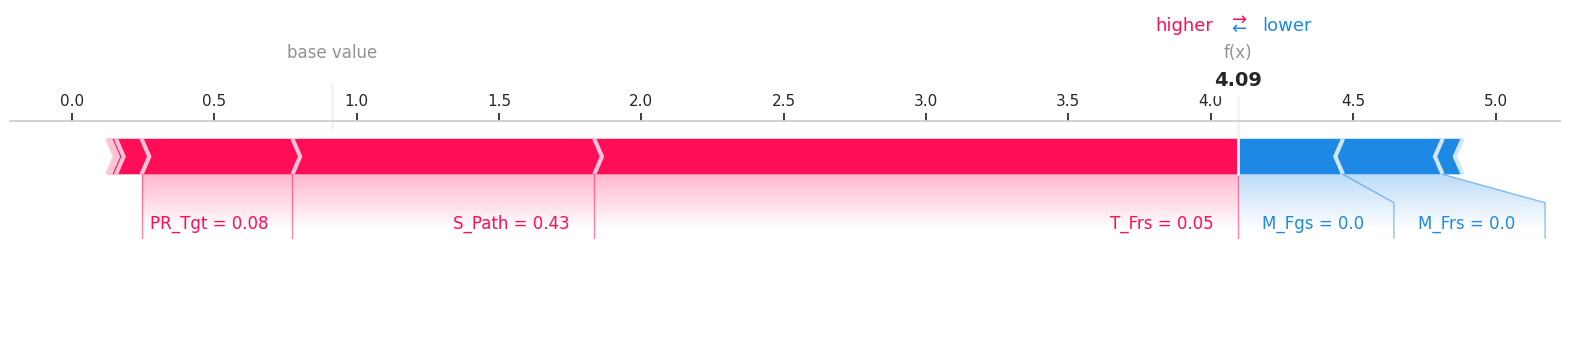

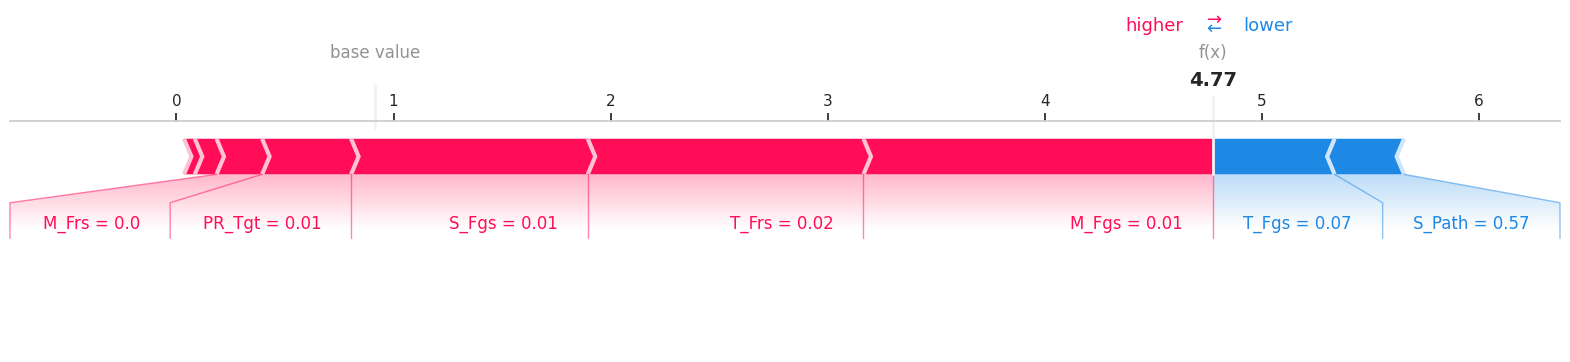

In [15]:
# 1. Feature Influence in Link (Class 1) Prediction visualized with SHAP Force Plots

# Abbreviated column names to save space in force plots
short_column_names = {
    'Page_Rank_Source': 'PR_Src',
    'Page_Rank_Target': 'PR_Tgt',
    'Shortest_Path': 'S_Path',
    'Source_Followers': 'S_Frs',
    'Source_Following': 'S_Fgs',
    'Target_Followers': 'T_Frs',
    'Target_Following': 'T_Fgs',
    'Mutual_Followers': 'M_Frs',
    'Mutual_Following': 'M_Fgs'
}

# Function to create SHAP force plots
def create_force_plot(explainer, shap_values, x_test, idx):
    
    rounded_shap_values = np.round(shap_values[idx].values, 2)
    rounded_feature_values = np.round(x_test.iloc[idx].values, 2)

    # use force_plot obj to generate plot
    shap.force_plot(
        explainer.expected_value,
        rounded_shap_values,  
        rounded_feature_values,
        feature_names=[short_column_names.get(col, col) for col in x_test.columns],
        matplotlib=True,
        show=False  
    )
    
    plt.grid(False)
    plt.gca().set_axisbelow(True)  
    plt.show()

# Function to generate legend using abbreviations for SHAP plots
def show_custom_legend(short_column_names):
    fig, ax = plt.subplots(figsize=(12, 1)) 
    ax.axis('off')

    legend_text = [f"{short_name} = {full_name}" for short_name, full_name in short_column_names.items()]
    
    ax.text(0.99, 0.5, "\n".join(legend_text), ha='right', fontsize=10, fontweight='bold')
    plt.subplots_adjust(right=1.0)
    plt.show()

# Function to generate SHAP plots
def generate_force_plots_for_random_samples(explainer, shap_values, x_test, short_column_names, num_samples=5):
    # Random samples are chosen
    sample_indices = random.sample(range(len(x_test)), num_samples)
    show_custom_legend(short_column_names)

    for idx in sample_indices:
        create_force_plot(explainer, shap_values, x_test, idx)


generate_force_plots_for_random_samples(explainer, shap_values, x_test, short_column_names, num_samples=5)


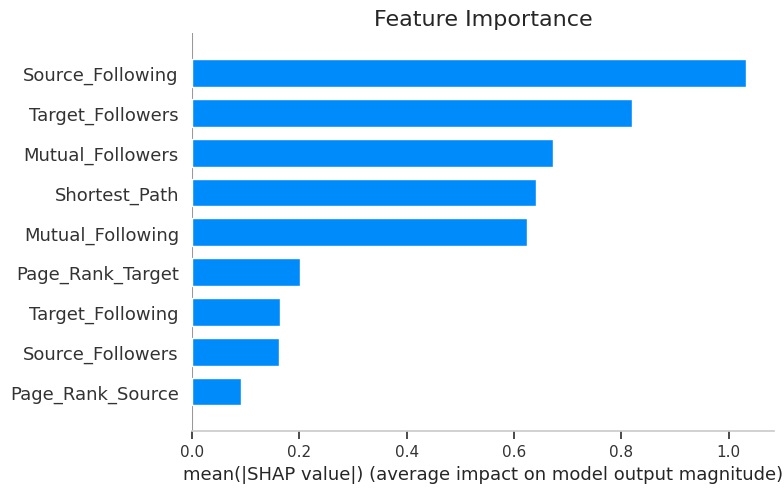

In [16]:
# 2. Feature Importance visualized using SHAP Summary Plot

import shap
import matplotlib.pyplot as plt

plt.grid(False)

plt.title('Feature Importance', fontsize=16)
shap.summary_plot(shap_values, x_test, plot_type="bar", show=True)

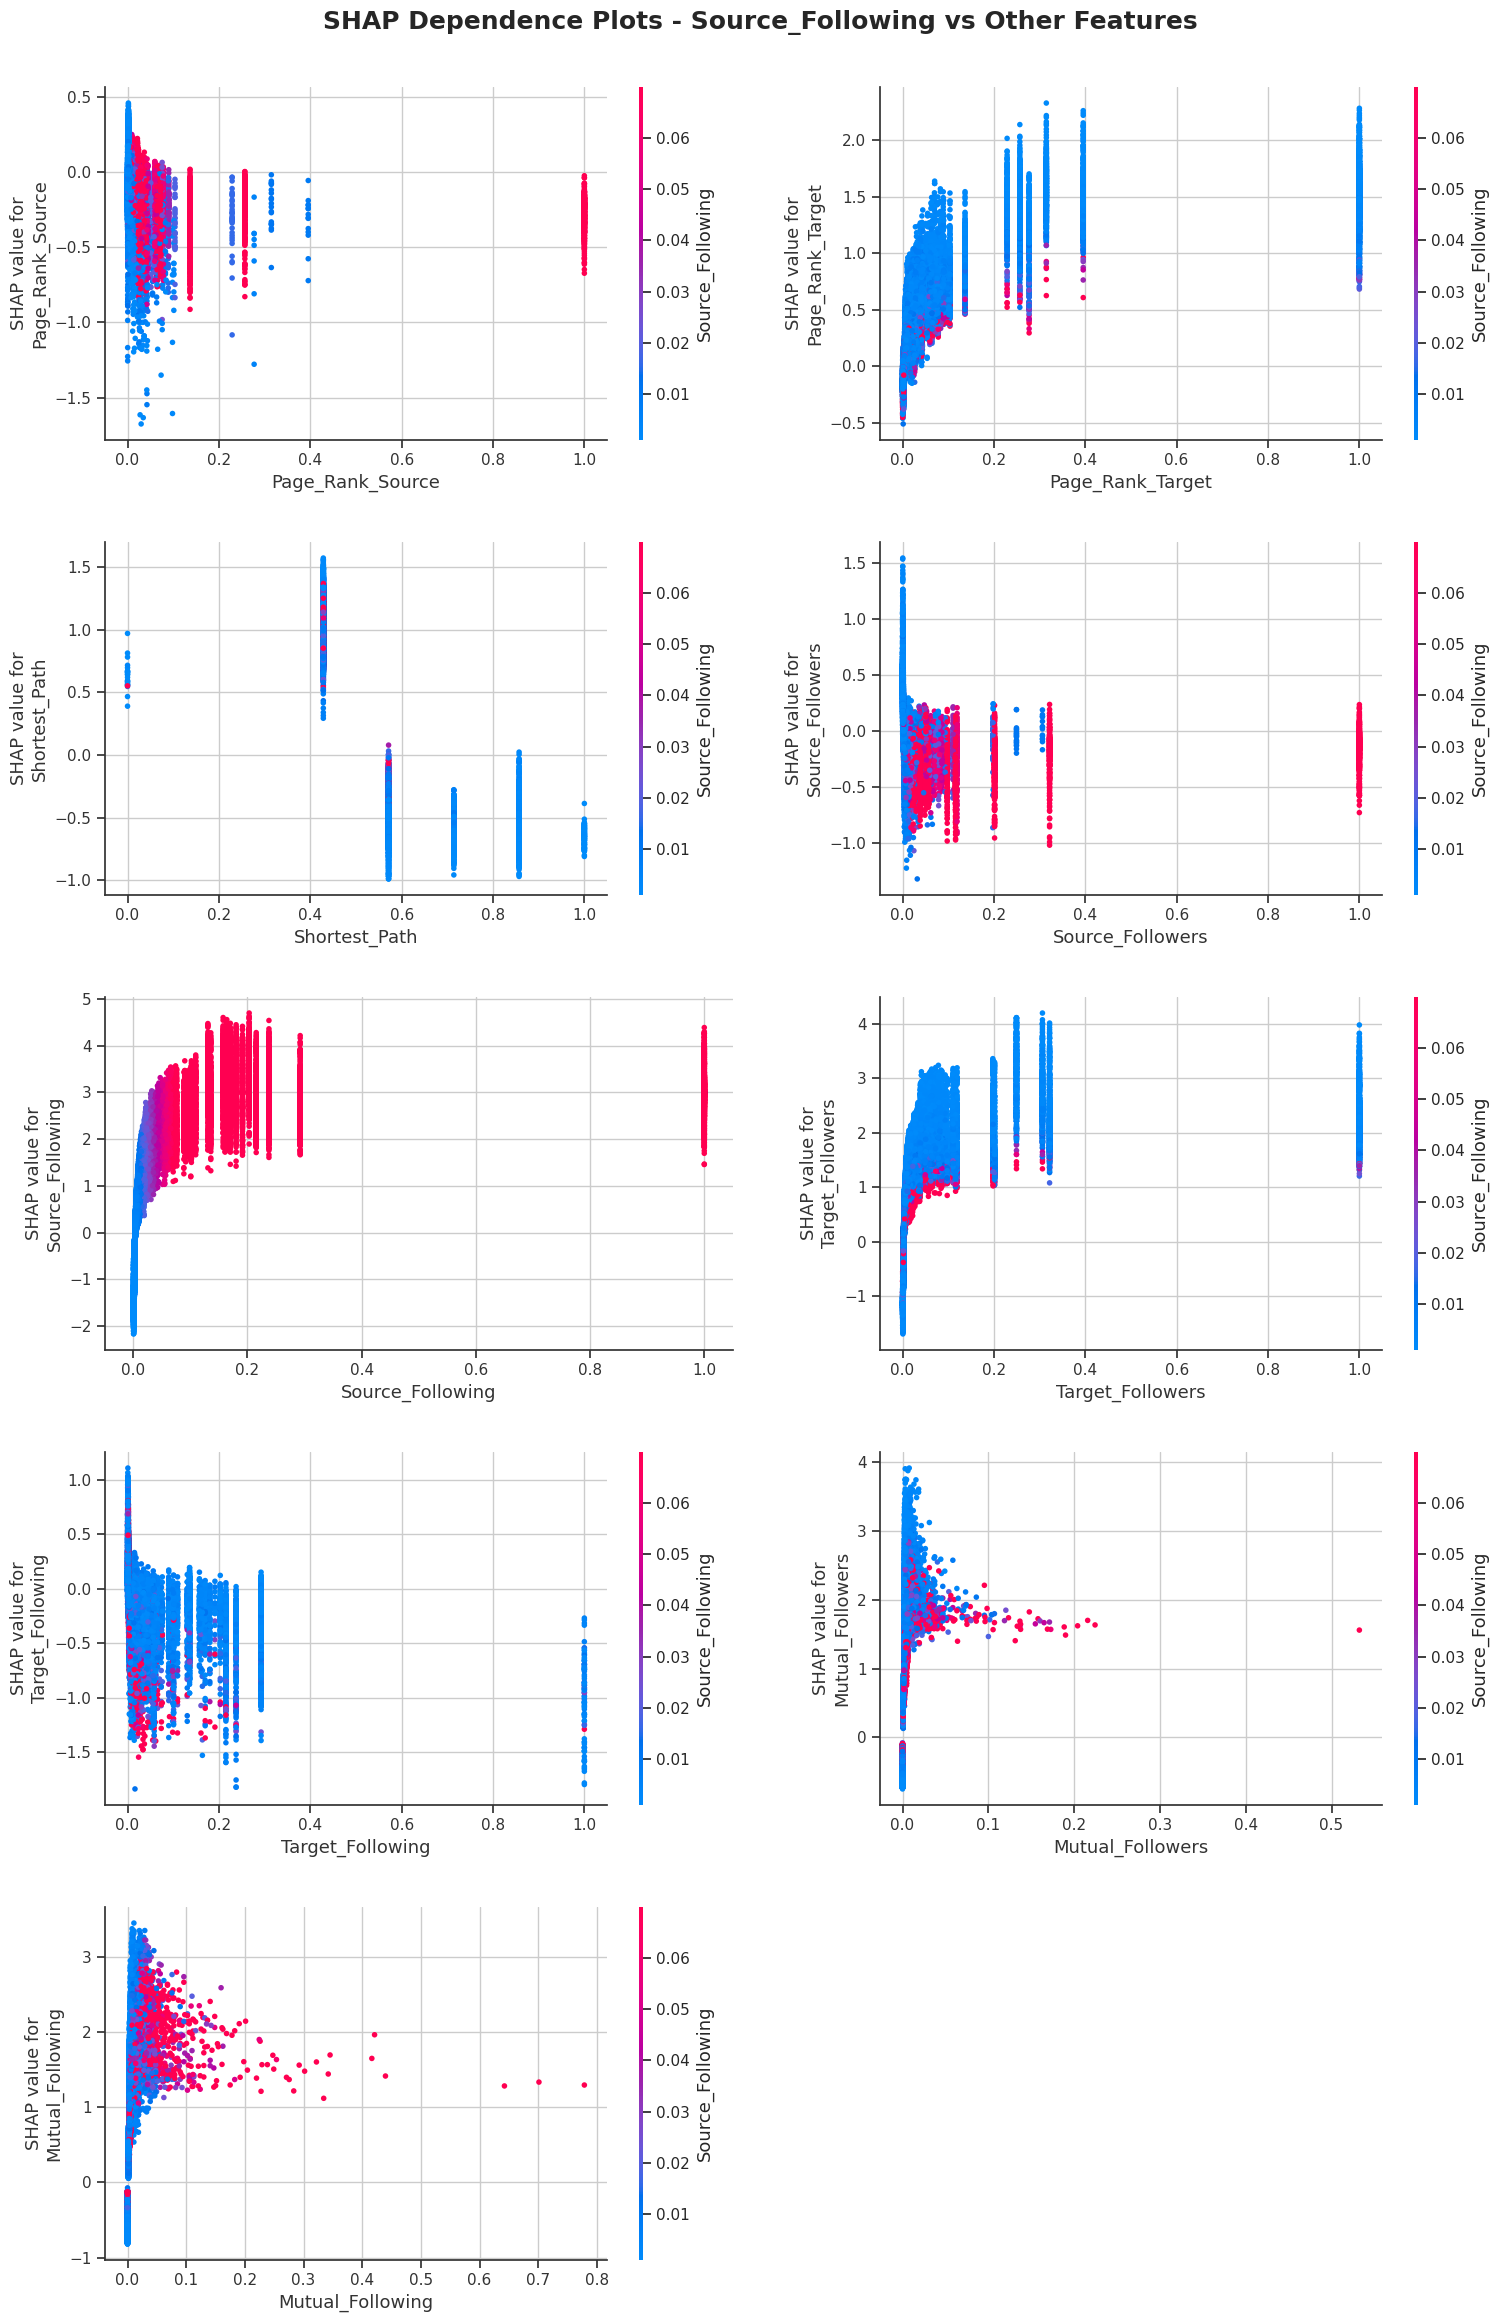

In [17]:
# 3. Feature Dependence Vs. Most Important Feature visualized with SHAP Dependence Plots

features = ['Page_Rank_Source', 'Page_Rank_Target', 'Shortest_Path', 
            'Source_Followers', 'Source_Following', 'Target_Followers', 
            'Target_Following', 'Mutual_Followers', 'Mutual_Following']

fig, axs = plt.subplots(nrows=5, ncols=2, figsize=(16, 24))

plt.subplots_adjust(hspace=0.8, wspace=0.6)  

fig.suptitle('SHAP Dependence Plots - Source_Following vs Other Features', fontsize=18, fontweight='bold')

# Loop through features
for idx, feature in enumerate(features):
    row_idx = idx // 2
    col_idx = idx % 2
    
    # Generate dependence plot for each feature
    shap.dependence_plot(feature, shap_values.values, x_test, interaction_index="Source_Following", ax=axs[row_idx, col_idx], show=False)
    
fig.delaxes(axs[4, 1])
plt.tight_layout(rect=[0, 0, 1, 1], pad=3.0)
plt.show()
